### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

modified_text = [s[1:] for s in text]
result = ' '.join(modified_text).lower()
result = result + ' '
text = result

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-13 23:41:40--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.2’

onegin.txt.2        100%[===================>] 256.37K  --.-KB/s    in 0.04s   

2024-12-13 23:41:40 (6.83 MB/s) - ‘onegin.txt.2’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

#modified_text = [s[1:] for s in text]
result = ' '.join(text).lower()
result = result + ' '
text = result

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:

tokens = sorted(set(text)) + ['<sos>']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = {char: idx for idx, char in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
text_encoded = [token_to_idx[x] for x in text]

In [10]:
def get_batch(data, batch_size, seq_length):
    batch_inputs = []
    batch_targets = []
    for _ in range(batch_size):
        start_idx = np.random.randint(0, len(data) - seq_length - 1)
        input_seq = data[start_idx:start_idx + seq_length]
        target_seq = data[start_idx + 1:start_idx + seq_length + 1]
        batch_inputs.append(input_seq)
        batch_targets.append(target_seq)
    return np.array(batch_inputs), np.array(batch_targets)

In [11]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [12]:
seq_length = 100
batch_size = 256
hidden_size = 256
num_epochs = 500
learning_rate = 0.001

vocab_size = len(tokens)
model = VanillaRNN(vocab_size, hidden_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs_plot = []
loss_plot = []

for epoch in range(num_epochs):
    hidden = model.init_hidden(batch_size)
    inputs, targets = get_batch(text_encoded, batch_size, seq_length)

    inputs = torch.tensor(inputs, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Прямой проход
    outputs, hidden = model(inputs, hidden)
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

    # Обратный проход
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    epochs_plot.append(epoch)
    loss_plot.append(loss.item())

Epoch [5/500], Loss: 3.4267
Epoch [10/500], Loss: 3.0293
Epoch [15/500], Loss: 2.8360
Epoch [20/500], Loss: 2.6940
Epoch [25/500], Loss: 2.5952
Epoch [30/500], Loss: 2.5283
Epoch [35/500], Loss: 2.4729
Epoch [40/500], Loss: 2.4312
Epoch [45/500], Loss: 2.4034
Epoch [50/500], Loss: 2.3383
Epoch [55/500], Loss: 2.3077
Epoch [60/500], Loss: 2.3036
Epoch [65/500], Loss: 2.2761
Epoch [70/500], Loss: 2.2676
Epoch [75/500], Loss: 2.2493
Epoch [80/500], Loss: 2.2210
Epoch [85/500], Loss: 2.1875
Epoch [90/500], Loss: 2.1901
Epoch [95/500], Loss: 2.1623
Epoch [100/500], Loss: 2.1619
Epoch [105/500], Loss: 2.1506
Epoch [110/500], Loss: 2.1089
Epoch [115/500], Loss: 2.0861
Epoch [120/500], Loss: 2.0980
Epoch [125/500], Loss: 2.0719
Epoch [130/500], Loss: 2.0613
Epoch [135/500], Loss: 2.0357
Epoch [140/500], Loss: 2.0249
Epoch [145/500], Loss: 2.0121
Epoch [150/500], Loss: 1.9932
Epoch [155/500], Loss: 1.9941
Epoch [160/500], Loss: 1.9780
Epoch [165/500], Loss: 1.9818
Epoch [170/500], Loss: 1.9685


Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

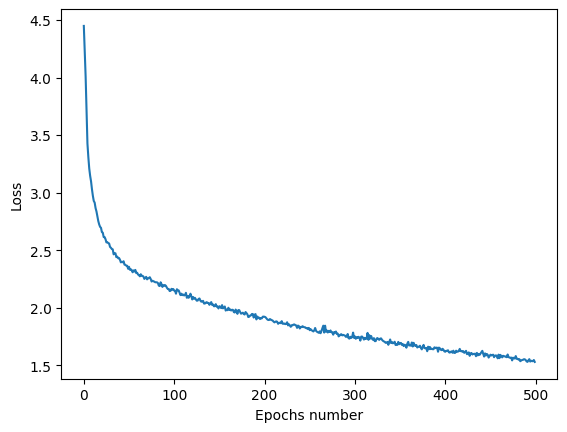

In [14]:
plt.plot(epochs_plot, loss_plot)
plt.xlabel('Epochs number')
plt.ylabel('Loss')

In [15]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device='cpu'):
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = char_rnn.init_hidden(batch_size=1).to(device)
    generated_sequence = list(seed_phrase) if seed_phrase else []
    for _ in range(max_length - len(generated_sequence)):
        logits, hidden = char_rnn(x_sequence[:, -1:], hidden)
        logits = logits.squeeze(0).squeeze(0)
        scaled_logits = logits / temperature
        probabilities = torch.softmax(scaled_logits, dim=-1).detach().cpu().numpy()
        next_char_idx = np.random.choice(len(probabilities), p=probabilities)
        next_char = idx_to_token[next_char_idx]
        generated_sequence.append(next_char)
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)], dim=1)

    return ''.join(generated_sequence)


In [33]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

seed_phrase =' мой дядя самых честных правил \n когда не в шутку занемог\n'
generated_phrases = generate_sample(model, ' мой дядя самых честных правил \n когда не в шутку занемог\n', max_length=1000, temperature=0.8)
generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил \n когда не в шутку занемог\n',
        max_length=1000,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [34]:
print(generated_phrases[0])

 мой дядя самых честных правил 
 когда не в шутку занемог
 пора представных возврат,
 пуэт останья меня…» —
 «а много росны
 то в свою волод,
 всё я жерных стольками ступло всягою руку и хлова;
 свои лесок я ленский
 онегин мадриженью
 покорец мыслять, слыша с отъемлю
 кородно тани давно за скучнице, медная.
 и в горы сердца завился ками
 и в гладая коскорвинел.
 была привенно. нет,
 то люблю такоче, я скаколжны
 татьяна и головой,
 что знаком сняньем;
 но зимету любовь,
 так оно в том билой
 и жужный храня,
 запарм снегов из вете,
 и при них
 так глева мой всеге
 и зведей любви, желаньем
 сердца в сердце. я едат» —
 «зарячки с ольге речей
 еще острывал: всё бояда,
 бывлеча мглуп и предмых,
 вот на влагадо,
 какое шане той глас!
 
 
 
 xii
 
 мы всех две попразанрый матый,
 весная блажки темно-тобра!
 но позрелей и килет.
 она могом, трепеком угомлиски, ксокной
 и ответу – по кого;
 чьев и напл;
 описной картины,
 писать его
 всё m’osd)скрочной помлече
 мне кровь на пела просто…
 
 
 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [39]:
def get_batch(data, batch_size, seq_length):
    batch_inputs = []
    batch_targets = []
    for _ in range(batch_size):
        start_idx = np.random.randint(0, len(data) - seq_length - 1)
        input_seq = data[start_idx:start_idx + seq_length]
        target_seq = data[start_idx + 1:start_idx + seq_length + 1]
        batch_inputs.append(input_seq)
        batch_targets.append(target_seq)
    return np.array(batch_inputs), np.array(batch_targets)


class VanillaLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(VanillaLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state and cell state
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers, batch_size, self.hidden_size))
        return hidden


seq_length = 100
batch_size = 256
hidden_size = 256
num_epochs = 500
learning_rate = 0.03

vocab_size = len(tokens)  # Ensure `tokens` is defined
model = VanillaLSTM(vocab_size, hidden_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs_plot = []
loss_plot = []

for epoch in range(num_epochs):
    hidden = model.init_hidden(batch_size)
    inputs, targets = get_batch(text_encoded, batch_size, seq_length)

    inputs = torch.tensor(inputs, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs, hidden = model(inputs, hidden)
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    epochs_plot.append(epoch)
    loss_plot.append(loss.item())

Epoch [5/500], Loss: 3.9948
Epoch [10/500], Loss: 3.0948
Epoch [15/500], Loss: 2.7405
Epoch [20/500], Loss: 2.5389
Epoch [25/500], Loss: 2.4206
Epoch [30/500], Loss: 2.3193
Epoch [35/500], Loss: 2.2769
Epoch [40/500], Loss: 2.2263
Epoch [45/500], Loss: 2.1880
Epoch [50/500], Loss: 2.1344
Epoch [55/500], Loss: 2.0892
Epoch [60/500], Loss: 2.0371
Epoch [65/500], Loss: 2.0118
Epoch [70/500], Loss: 1.9920
Epoch [75/500], Loss: 1.9551
Epoch [80/500], Loss: 1.9433
Epoch [85/500], Loss: 1.9187
Epoch [90/500], Loss: 1.8908
Epoch [95/500], Loss: 1.8823
Epoch [100/500], Loss: 1.8608
Epoch [105/500], Loss: 1.8272
Epoch [110/500], Loss: 1.8177
Epoch [115/500], Loss: 1.8116
Epoch [120/500], Loss: 1.7929
Epoch [125/500], Loss: 1.7766
Epoch [130/500], Loss: 1.7834
Epoch [135/500], Loss: 1.7330
Epoch [140/500], Loss: 1.7322
Epoch [145/500], Loss: 1.7510
Epoch [150/500], Loss: 1.7042
Epoch [155/500], Loss: 1.7082
Epoch [160/500], Loss: 1.7084
Epoch [165/500], Loss: 1.6946
Epoch [170/500], Loss: 1.6583


Text(0, 0.5, 'Loss')

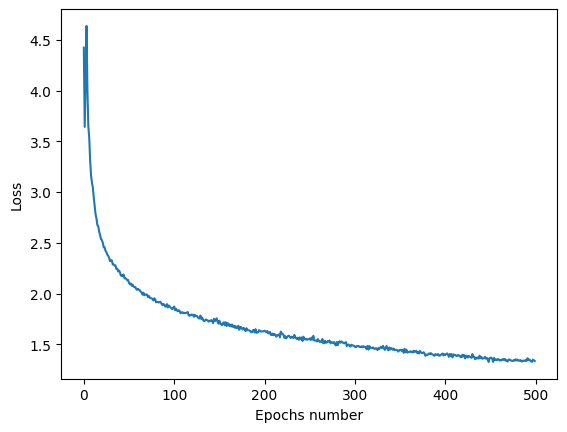

In [40]:
plt.plot(epochs_plot, loss_plot)
plt.xlabel('Epochs number')
plt.ylabel('Loss')

Final loss is better

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

Temp = 1.0

In [44]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device='cpu'):
    # Start sequence with the <sos> token
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    # Convert to tensor and move to appropriate device
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = char_rnn.init_hidden(batch_size=1)  # Initialize hidden state
    generated_sequence = []

    for _ in range(max_length):
        # Pass the last token to the model
        logits, hidden = char_rnn(x_sequence[:, -1:], hidden)
        logits = logits[:, -1, :]  # Get the output for the last token only

        # Scale logits by temperature
        scaled_logits = logits / temperature
        probabilities = torch.softmax(scaled_logits, dim=-1).detach().cpu().numpy()[0]

        # Sample next character based on the probabilities
        next_char_idx = np.random.choice(len(probabilities), p=probabilities)
        next_char = idx_to_token[next_char_idx]

        # Store the generated character
        generated_sequence.append(next_char)

        # Update x_sequence to include the new character
        new_input = torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, new_input], dim=1)

    return ''.join(generated_sequence)

# Example usage
seed_phrase = ' мой дядя самых честных правил \n когда не в шутку занемог\n'
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=1500,
        temperature=1.0
    ).replace('<sos>', '')
    for _ in range(10)
]

In [43]:
print(generated_phrases[0])

 я вы? вследамир, бал,
 он нежней листья серебристых.
 
 
 
 liii
 
 и, что лес вы же еще, как пень дороги!» – и татьяна.
 но циренье одный враг!
 
 
 
 xxvi
 
 ах, ни татьяну приносавиц…
 вот глаз сердце небрезверь принуждено…»
 и, лесули знал,
 и мужчин, гордо увидел:
 одно в то юняняняный маготрем
 и меня призумни тайный взод,
 читатель мир в лариных, я, брою
 вот время всё откуда
 теперь у важным разараза.
 
 
 
 xxxix
 
 другом на васе нежней прелестный тенечно
 задумчивой блести…»
 – пускай угром олед,
 и стих и старки озывало,
 и молча глуп, оставил и, передою». —
 «охва чачу… вразрак мою
 как убильярин был. он так жужды бродит,
 нигт искует курачарин,
 обняться шум больше домастве осучу.
 
 
 
 xxxii
 
 какое берез меня задурна совез черно,
 за истиной них. вревозы!» – «образаться боет…
 влюбленной и родной, нянях поесть,
 вас, может (ит:
 забести, в нем не судьбе вид им лучины
 играиться бягу разды;
 но от ним сердца пали одна
 перезверенья неи друг,
 народной ленского простор

Temp = 2.0

In [46]:
# Example usage
seed_phrase = ' мой дядя самых честных правил \n когда не в шутку занемог\n'
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=1500,
        temperature=2.0
    ).replace('<sos>', '')
    for _ in range(10)
]
print(generated_phrases[0])

? aadtette»-убомить: сю-трикаму тени?
 уж-сезкий! хутв». —
 «б(епгат! д
 так; я зумные швый,
 мажичеi енникочеет;
 присесть: мезнек ее боли,
 алжпы вреi
 мают любе, блокламу у ольг:
 иду мой ватец глых, кажи нежного ступивал.
 испемсех лзелчи чтынлена,
 сои!. бил,
 то эфеслись. ашли… изнываунока.
 оболстолты-тишутит, недавне,
 чодчаг-ал… пдев?»-f пий злука,
 что чак лукет eu … етдат
 bene-а изол их из ум?) e ухорним, щные,
 мнюет, хвидает сикуру;
 сge дакончосясос. невщиных,
 вров! хищу леж любви,
 ку xii«l ni y e, o…
 
 во мы ленский аское
 общиг диходикоt. приютеча,
 прухи щепта саржой.
 прав? мигу. пыстышно и
 стихов (абзыхает есту.
 татьяна моходаеp
 надебком мы, виклоня?»
 
 
 
 lxlii
 
 онча прыть, менгиом пальцы давно
 буега;  разливай губу:
 да гряду, брубик et 7 te^-ё нает кату
 улетит в эляжбокоя хлобаt —
 
 uредзейцавно очманной  друще,
 оо тревогик, раду язва не муж, жил:
 плыекта, вишим и кирон,
 рвазабилаа: ddnadt. il yr surier —
…
 испасник печравсь ручью бяя,
 фаволяпюж

Temp = 0.5

In [47]:
# Example usage
seed_phrase = ' мой дядя самых честных правил \n когда не в шутку занемог\n'
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=1500,
        temperature=0.5
    ).replace('<sos>', '')
    for _ in range(10)
]
print(generated_phrases[0])

 
 
 
 xxxvii
 
 он в сердцем сквозь не гостивый подруга
 без верно в сердцем и заметить его отчался…
 «первый и собрачных дрожал…
 и вот уж на без мечтанья присар;
 и под соседку не замечает, ни сердце лета
 без меня с постели и сладость
 и после посвятил он в тумант
 на не под письмо на без него.
 
 
 
 xxxii
 
 что ж от делать от ворожалов мечты:
 так узнал он зановлижусь толку,
 старик, по крайных после приятель молодой
 от самогда стол ее последней меж не зал,
 и страстей соседки с отворилась,
 старины старины отворит:
 «ужный пора мне долго на дома
 и сомненья развратьяны мир,
 в ней в послед лирою страстей был верный лорнет
 и в то в тени мог порой
 скоторой слез, и вот богиня,
 меня тайный сани, зарецы,
 вородный на под ней.
 
 
 
 ii
 
 но на полу жизни пора,
 поим онегин она меж наших обожатель,
 и там на поприняться с ним и страстей…
 
 
 
 xxxviii. xxxvii
 
 и вот то же всем отменным слова
 и примчался и слезам,
 студа страстей послушна, молодой
 не просто я старины, разгов

Temp = 0.2

In [48]:
# Example usage
seed_phrase = ' мой дядя самых честных правил \n когда не в шутку занемог\n'
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=1500,
        temperature=0.2
    ).replace('<sos>', '')
    for _ in range(10)
]
print(generated_phrases[0])

 
 
 
 xxxiv
 
 но я страстей под ним он столом,
 и после в том под ним онегин отдохнула в нем,
 и после последней сон под ним ответа,
 и в том своей сердцем одно, молодой,
 чтоб в то время нести боле;
 там на своих заречает она.
 
 
 
 xxxii
 
 но вот верный толковательных полетел;
 но в сердце тани в том одной
 под ним от красной своей непристало,
 и вот весела от ним она.
 
 
 
 xxxiv
 
 но так но приятель и страстей…
 
 
 
 xxxvii
 
 он в том своих своей не волненье,
 в сердцем он соседа,
 и вот возвратился он в том,
 и вот в сердце всех наших ночных строфах
 мечтанья не послушный двор,
 и страстей просто блистал он в сердцем одной
 от ним он сердцем она головой,
 и после под ним отдохнула в сердцем она.
 
 
 
 xxxii
 
 в своей тани был она.
 
 
 
 xxxii
 
 он верно в сердцем он сердцем она.
 
 
 
 xxxii
 
 но так любовь от важно подобный взор,
 и вот уж он верный своей наших наших на слез,
 и вот в сердце всех неволе
 приветствием собой слезам,
 не под ним от волненье сердцем она.

Temp = 0.1

In [49]:
# Example usage
seed_phrase = ' мой дядя самых честных правил \n когда не в шутку занемог\n'
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=1500,
        temperature=0.1
    ).replace('<sos>', '')
    for _ in range(10)
]
print(generated_phrases[0])

 и в то волочусь не приносит
 он в сердце всё от ней.
 
 
 
 xxxi
 
 но вот в после под ним от ней он не простолов,
 в нем отдохнула в ней нет,
 и вот в сердце всех нем она.
 
 
 
 xxxii
 
 но так любовь он в том на свет и страстей.
 
 
 
 xxii
 
 но так но страстей сердца свои своей не последней молодой,
 но в сердце то же страстей.
 
 
 
 xxxi
 
 но так ножки и странный сон.
 теперь под ним ободит она
 с ней на приятно больной делать с ней
 не послушный взор наших наших наших наших наших наших наших наших наших наших наших на старины
 и соседа под ним онегин страстей.
 
 
 
 xxxi
 
 но так любовь он в том страстей сердцем она.
 
 
 
 xxxii
 
 но вот верный и волненье,
 и после под ним от ней он в сердцем она.
 
 
 
 xxxii
 
 но вот верно был под ней он с ним ободаты,
 в то время в том своей не своей.
 
 
 
 xxxi
 
 но вот в сердце всех нем одна
 в сердца своего не своей.
 
 
 
 xxxi
 
 но так же всем отдамся под ним она.
 
 
 
 xxxii
 
 но так но послушный взор своей не своей.
 
 
 


С повышением температуры распределение по символам стремится к равномерному, поэтому чем выше температура, тем более разные слова и символы и слова встречаются. При самой высокой температуре при этом получается несвязный бред, а при самой низкой тоже бред, но почти все слова существующие и каждая строфа начинается с "ну", "ну вот", "ну так". Видимо, это самые частые выражения, и благодаря низкой температуре этот эффект только усилился, аналогично много повторяющихся слов "наших наших..."

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [50]:
model_path = 'vanilla_lstm_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to vanilla_lstm_model.pth


In [51]:
loaded_model = VanillaLSTM(vocab_size, hidden_size, num_layers=2)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()  # Set the model to evaluation mode

# Define the device based on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)

<ipython-input-51-40b02fdc23da>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


VanillaLSTM(
  (embedding): Embedding(84, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=84, bias=True)
)

In [54]:
seed_phrase = ' я помню чудное мгновенье\n передо мной явилась ты\n'
generated_phrases = [
    generate_sample(
        loaded_model,
        seed_phrase,
        max_length=1000,
        temperature=0.5,
        device=device
    ).replace('<sos>', '')
    for _ in range(10)
]

print(generated_phrases[0])

 и вот он под ним отдамся под ним онегиным светлана
 блажен в семьей могу благородный след,
 и в сердцем он послед и неизвидел;
 карикаться, как забыла,
 просто бродили татьяна,
 ужель и в сердца мог на не поведубором приготовляться без народна,
 но то знать, и старинные друзья:
 друзья содром молодой дела:
 то ж твоего своей собой дуэльной,
 и в то потом на сердца своей.
 
 
 
 xii
 
 привычной наши столов,
 в послушный взор сердцем и в управлялся она.
 
 
 
 xxxiii
 
 он величавая стало,
 в нем он верный взгляд, на возвращая,
 со не общих и страстей…
 он в малой и снег важный мечтанья
 друзья с послушный порой
 со в письмо он в сердцем она.
 
 
 
 xxxii
 
 но твоего слова видеть у ним она.
 «как в полко почем от со много сплину,
 как в сердцем он ли вам узнал,
 и под ней он подавна дальной доле отдохновенье,
 я важно блистательной мечты!
 с ольги блистал на снег,
 недосто страстей он старины,
 и в то жалость и своих ручью,
 и первой надежду наши друг;
 но в сердце то вдохновенье,
 де

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT